In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_SOURCE = "raw_csi/betty/"
def _read_csi_next(pcapfile, csi_size):
    """
    Note: Designed for internal use only.
    Parameters
    ----------
        pcapfile : File Object
        csi_size : Expected length of CSI in bytes. NFFT * 4
    """

    # Read Frame Size
    pcapfile.seek(8, os.SEEK_CUR)
    frame_size = int.from_bytes(
        pcapfile.read(4),
        byteorder='little',
        signed=False
    )

    # Skip some stuff
    pcapfile.seek(56, os.SEEK_CUR)

    # Read CSI data
    pcapfile.seek(8, os.SEEK_CUR)
    csi = np.frombuffer(
        pcapfile.read(csi_size),
        dtype=np.int16,
        count=int(csi_size / 2)
    )

    # Skip any zero-padding
    pcapfile.seek((frame_size - csi_size - 60), os.SEEK_CUR)

    return csi


def read_csi(pcap_file_path):
    """
    Read CSI data from PCAP file.
    Supports only 40MHz bandwidth,
    and only one Mac ID. You have
    to remove null subcarriers
    yourself.
    Parameters
    ----------
        pcap_file_path : str
    """

    bandwidth = 80

    NFFT = int(bandwidth * 3.2)  # Number of channels in FFT
    chunksize = 1024

    csi = np.zeros((chunksize, NFFT * 2), dtype='int16')

    with open(pcap_file_path, 'rb') as pcapfile:
        filesize = os.stat(pcap_file_path).st_size
        pcapfile.seek(24, os.SEEK_SET)

        npackets = 0
        while pcapfile.tell() < filesize:
            if not (npackets % chunksize):
                csi = np.vstack((csi, np.zeros((chunksize, NFFT * 2), dtype='int16')))

            csi[npackets] = _read_csi_next(pcapfile, NFFT * 4)

            npackets += 1

    # Convert CSI complex numbers to Magnitude.
    csi_converted = np.abs(
        np.fft.fftshift(csi[:npackets, ::2] + 1.j * csi[:npackets, 1::2], axes=(1,))
    )

    return csi_converted

def window(dataFrame, n):
    #window size=n, overleap=(n-1)/2 at each side
    return dataFrame.rolling(n, center=True).mean()

def get_data_class():
    dataset = pd.DataFrame()
    target = []
    class_names = ['a_human', 'exercise', 'girando', 'sitting']
    for index, class_name in enumerate(class_names):
        for number in range(20):
          n = number + 1
          csi = pd.DataFrame(read_csi(DATA_SOURCE+class_name+str(n)+'.pcap'))
          csi.drop(csi.tail(350).index,inplace=True)
          csi.drop(csi.head(350).index,inplace=True)
          # adding windows for smoothing data
          windows = [5, 9]
          initial = csi
          for i in windows:
            windowed = window(initial, i)
            csi = pd.concat([csi, windowed], axis=1)
          # Deleting rows with NaN values
          csi.dropna(inplace=True)
          target = target + [index] * csi.shape[0]
          dataset = pd.concat([dataset, csi], axis=0)

    return dataset, target

if __name__ == '__main__':

    # 80 MHz
    nullsubcarriers  = np.array([x+128 for x in [-128, -127, -126, -125, -124, -123, -1, 0, 1, 123, 124, 125, 126, 127]])
    pilotsubcarriers = np.array([x+128 for x in [-103, -75, -39, -11, 11, 39, 75, 103]])

    
    csi, target = get_data_class()

    csi = csi.drop(columns=nullsubcarriers)
    csi = csi.drop(columns=pilotsubcarriers)
    

    # I have not tested this on 80 MHz data yet. It should work, but I can't guarantee it.
    #cc = csi.to_numpy()

    #plt.figure(figsize=(30, 30))
    #plt.imshow(np.transpose(cc))
    #plt.ylabel('value')
    #plt.show()
    #normalized = preprocessing.normalize(cc) 
    csi.to_csv('dataset.csv')
    pd.DataFrame(data=target).to_csv('targets.csv')

In [2]:
X = csi.to_numpy()
Y = np.array(target).reshape((-1,1))
samples, feature_size = X.shape

In [3]:
print(X.shape)
print(Y.shape)

(123360, 702)
(123360, 1)


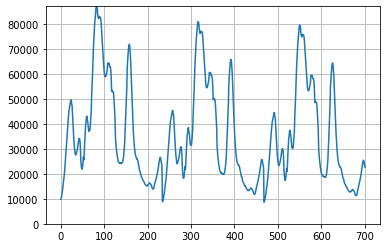

In [4]:
# check variances:
variances = np.zeros((feature_size,1))
for i_idx in range(0,feature_size):
    tmp_i = X[:,i_idx]
    mean_i = np.mean(tmp_i)
    var_ii = np.mean(np.multiply((tmp_i - mean_i), (tmp_i - mean_i)))
    variances[i_idx] = var_ii

fig = plt.figure()
ax = plt.axes()
plt.plot(variances)
plt.ylim(0, np.amax(variances))
plt.grid()
plt.show()

In [5]:
X_normalized = np.zeros(X.shape)
for i_idx in range(0,feature_size):
    tmp_i = X[:,i_idx]
    mean_i = np.mean(tmp_i)
    var_ii = np.mean(np.multiply((tmp_i - mean_i), (tmp_i - mean_i)))
    sigma_ii = np.sqrt(var_ii)
    X_normalized[:,i_idx] = np.divide(tmp_i - mean_i,sigma_ii)

In [6]:
# check variance and covariances:
#X_normalized = X


KeyboardInterrupt: 

In [7]:
covariance = np.cov(X_normalized,rowvar=False)
print (covariance)

[[ 1.00000811  0.9970488   0.99476872 ... -0.34527415 -0.32807167
  -0.31312943]
 [ 0.9970488   1.00000811  0.99797654 ... -0.35750886 -0.34106497
  -0.32708008]
 [ 0.99476872  0.99797654  1.00000811 ... -0.33970548 -0.32321595
  -0.30913491]
 ...
 [-0.34527415 -0.35750886 -0.33970548 ...  1.00000811  0.99854051
   0.99434683]
 [-0.32807167 -0.34106497 -0.32321595 ...  0.99854051  1.00000811
   0.99836184]
 [-0.31312943 -0.32708008 -0.30913491 ...  0.99434683  0.99836184
   1.00000811]]


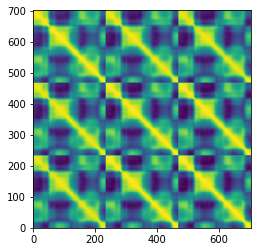

In [8]:
fig = plt.figure()
ax = plt.axes()
plt.imshow(covariance, extent=[0, feature_size-1, 0, feature_size-1])
plt.show()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
